# Corruption citations in political axes

A ideia desse notebook é criar a visualização de dados em usando o gráfico de eixos político-econômicos de cada partido português, usando as cores para representar cada partido e o tamanho do ponto sendo proporcional ao número de citações a respeito de corrupção.

# Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import bokeh
import re
import os
import copy
import imageio
import math

# Dados

Os dados usados serão as planilhas de citações diretas e indiretas de corrupção usando as funções fornecidas pelo André Seidel para gerar esse conjunto de dados.

Vale lembrar que nesse exemplo foram usadas apenas as primeiras 2 atas de forma manual, mas para um *input* semelhante com mais dados de entrada funcionará de forma semelhante.

In [2]:
direct_citations = pd.read_csv('direct_citations.csv')
indirect_citations = pd.read_csv('indirect_citations.csv')

In [3]:
direct_citations.head()

,Transcript,Date,Position,Person,Party,Text,Subject,key
0,DAR-001,17 DE SETEMBRO DE 2020,231.0,Filipa Roseta,PSD,O Prof. António Costa Silva disse hoje de manh...,Declarações políticas,17 DE SETEMBRO DE 2020Declarações políticas
1,DAR-001,17 DE SETEMBRO DE 2020,233.0,Filipa Roseta,PSD,… e que de cada vez que há um problema e há um...,Declarações políticas,17 DE SETEMBRO DE 2020Declarações políticas
2,DAR-001,17 DE SETEMBRO DE 2020,277.0,André Ventura,CH,"Esperei tantos meses, tantos meses pelo tal pl...",Declarações políticas,17 DE SETEMBRO DE 2020Declarações políticas
3,DAR-001,17 DE SETEMBRO DE 2020,309.0,Presidente,NaN,"Damos, assim, por terminada a discussão do seg...","Petição 13/XIV, Projeto de Resolução 550/XIV, ...","17 DE SETEMBRO DE 2020Petição 13/XIV, Projeto ..."
4,DAR-001,17 DE SETEMBRO DE 2020,310.0,André Silva,PAN,"Sr. Presidente, Sr.as e Srs. Deputados: Começo...","Petição 13/XIV, Projeto de Resolução 550/XIV, ...","17 DE SETEMBRO DE 2020Petição 13/XIV, Projeto ..."


In [4]:
indirect_citations.head()

,Transcript,Date,Position,Person,Party,Text,Subject,key
0,DAR-001,17 DE SETEMBRO DE 2020,5.0,Luís Moreira Testa,PS,"Sr. Presidente, Srs. Deputados: Portugal, País...",Declarações políticas,17 DE SETEMBRO DE 2020Declarações políticas
1,DAR-001,17 DE SETEMBRO DE 2020,6.0,Ana Paula Vitorino,PS,Muito bem!,Declarações políticas,17 DE SETEMBRO DE 2020Declarações políticas
2,DAR-001,17 DE SETEMBRO DE 2020,7.0,Luís Moreira Testa,PS,Mas também não é de somenos importância que se...,Declarações políticas,17 DE SETEMBRO DE 2020Declarações políticas
3,DAR-001,17 DE SETEMBRO DE 2020,8.0,Santinho Pacheco,PS,Muito bem!,Declarações políticas,17 DE SETEMBRO DE 2020Declarações políticas
4,DAR-001,17 DE SETEMBRO DE 2020,9.0,Luís Moreira Testa,PS,"A meio do mês de outubro, o Governo apresentar...",Declarações políticas,17 DE SETEMBRO DE 2020Declarações políticas


# Convertendo para valores de datetime

In [5]:
def datetime(date):
    months = {
        'JANEIRO' : '01',
        'FEVEREIRO' : '02',
        'MARÇO' : '03',
        'ABRIL' : '04',
        'MAIO' : '05',
        'JUNHO' : '06',
        'JULHO' : '07',
        'AGOSTO' : '08',
        'SETEMBRO' : '09',
        'OUTUBRO' : '10',
        'NOVEMBRO' : '11',
        'DEZEMBRO' : '12',
    }

    date = date.strip().replace(' DE ', '/').split('/')
    date[1] = months[date[1]]
    date = '/'.join(date)

    return date

direct_citations['Date'] = pd.to_datetime(direct_citations['Date'].apply(datetime)).dt.date
indirect_citations['Date'] = pd.to_datetime(indirect_citations['Date'].apply(datetime)).dt.date

# Declarando informações

In [6]:
#Conferir PCP e PEV
#IL sem informação
# atenção para os partidos com ???

infos = {
    'PS'     : {
        'color' : '#FF66FF',
        'orientation' : 'Esquerda',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido4_0.gif',
        'coordinates' : (-2.5, 3.1),
    },
    'PSD'    : {
        'color' : '#F68A21',
        'orientation' : 'Direita',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido3_1.gif',
        'coordinates' : (1.6, -1),
    },
    'BE'     : {
        'color' : '#D21F1B',
        'orientation' : 'Esquerda',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido14_0.gif',
        'coordinates' : (-3.5, 0.5),
    },
    'PCP'    : {
        'color' : '#FF0000',
        'orientation' : 'Esquerda',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido1_0.gif',
        'coordinates' : (-3.5, -4.7),
    },
    'CDS-PP' : {
        'color' : '#0091DC',
        'orientation' : 'Direita',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido2_0.gif',
        'coordinates' : (2.5, -2.1),
    },
    'PAN'    : {
        'color' : '#036A84',
        'orientation' : 'Esquerda',
        'url_image' : 'http://www.cne.pt/sites/default/files/pan_2014.jpg',
        'coordinates' : (-3.4, 3.2),
    },
    'PEV'    : {
        'color' : '#73BE43',
        'orientation' : 'Esquerda',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido10_0.gif',
        'coordinates' : (-2.1, -2.5),
    },
    'CH'     : {
        'color' : '#333399',
        'orientation' : 'Direita',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido_chega.png',
        'coordinates' : (5, -3.6),
    },
    'IL'     : {
        'color' : '#00AEEE',
        'orientation' : 'Direita',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido_liberal.png',
        'coordinates' : (5, 5) #???,
    },
    'JPP'    : {
        'color' : '#0E766D',
        'orientation' : 'Centro',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido_jpp.jpg',
        'coordinates' : (0, 0) #???,
    },
    'PPM'    : {
        'color' : '#014A94',
        'orientation' : 'Direita',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido5_0.gif',
        'coordinates' : (5, 0) #???,
    },
    'NC'     : {
        'color' : '#FEAB19',
        'orientation' : 'Direita',
        'url_image' : 'http://www.cne.pt/sites/default/files/partido_nos_cidadaos.jpg',
        'coordinates' : (5, -5) #???,
    },
    'L'      : {
        'color' : '#98C75A',
        'orientation' : 'Esquerda',
        'url_image' : 'http://www.cne.pt/sites/default/files/livre.png',
        'coordinates' : (-4.6, 2.7),
    },
}

In [7]:
#Upar pasta zippada e rodar o código de baixo

#!unzip parties_logos.zip

In [8]:
#Dessa forma é só upar a pasta com as imagens baixadas para não depender da internet

'''
for party in infos:
    infos[party]['url_image'] = 'content/parties_logos/' + party + '.png'
'''

"\nfor party in infos:\n    infos[party]['url_image'] = 'content/parties_logos/' + party + '.png'\n"

Vamos também aproveitar e remover se houver partidos para Presidente e secretários e depois remover todas as linhas sem partidos

In [9]:
def clean(citations):
    not_politicians = ['Presidente', 'Secretária', 'Secretário', 'Ministra', 'Ministro']
    for not_politician in not_politicians:
        citations.loc[citations['Person'].str.contains(not_politician), 'Party'] = np.nan
    citations.dropna(axis=0, inplace=True)
    return citations

direct_citations = clean(direct_citations)
indirect_citations = clean(indirect_citations)

# Criando os DataFrames

Ideia é criar um dicionário de tabelas mapeado por data e dessa forma dividir as citações de cada um dos partidos, dentro dessa tabela também vão existir colunas para as contagens de citações, cor do partido, url da logo e coordenadas político-econômicas

In [10]:
def create_dataframes(citations, infos):
    df_dict = {}
    dates = citations['Date'].unique().tolist()
    grouped = citations.groupby(citations['Date'])
    
    for i in range(len(dates)):

        group = grouped.get_group(citations['Date'].unique().tolist()[i])

        df_dict[str(dates[i])] = {            
            'Party' : [],
            'Count' : [],
            'Color' : [],
            'Orientation' : [],
            'Image' : [],
            'X_coordinate' : [],
            'Y_coordinate' : [],
        }
        
        for party in infos:
            
            df_dict[str(dates[i])]['Party'].append(party)
            df_dict[str(dates[i])]['Count'].append(len(group.loc[group['Party'] == party]))
            df_dict[str(dates[i])]['Color'].append(infos[party]['color'])
            df_dict[str(dates[i])]['Orientation'].append(infos[party]['orientation'])
            df_dict[str(dates[i])]['Image'].append(infos[party]['url_image'])
            df_dict[str(dates[i])]['X_coordinate'].append(infos[party]['coordinates'][0])
            df_dict[str(dates[i])]['Y_coordinate'].append(infos[party]['coordinates'][1])

        df_dict[str(dates[i])] = pd.DataFrame(df_dict[str(dates[i])])


    return df_dict, [str(date) for date in dates]

direct_dict, direct_dates = create_dataframes(direct_citations, infos)
indirect_dict, indirect_dates = create_dataframes(indirect_citations, infos)

# Criando os gráficos em Seaborn para cada dia

In [11]:
def create_graph(df, date):
    colors = {}

    for i in range(len(df)):
        colors[df['Party'][i]] = df['Color'][i]

    sns.set_style('darkgrid')
    sns.set_context('paper')
    sns.set(font_scale=1.1)

    plt.figure(figsize=(14, 14))
    ax = sns.scatterplot(x='X_coordinate', y='Y_coordinate', data=df,
                         palette=colors, hue='Party', size='Count', 
                         alpha=0.5, sizes=(50, 7500), size_norm=(0, 62))

    ax.set_title('Eixo político-econômico: Acumulado até ' + str(date), y=1.04, fontsize='x-large')

    ax.set(xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))
    
    ax.axhline(y=0, linewidth=0.5, color='black')
    ax.axvline(x=0, linewidth=0.5, color='black')

    for i in range(len(df)):
        ax.annotate(df['Party'][i],
                    xy=(df['X_coordinate'][i], df['Y_coordinate'][i]),
                    xycoords='data',
                    xytext=(df['X_coordinate'][i]-0.15, df['Y_coordinate'][i]+0.15),
                    )
        ax.annotate(df['Count'][i],
            xy=(df['X_coordinate'][i], df['Y_coordinate'][i]),
            xycoords='data',
            xytext=(df['X_coordinate'][i]+0.1, df['Y_coordinate'][i]-0.1),
            )
    
    ax.legend(fancybox=True, shadow=True)

    plt.xticks(np.arange(-5, 6, 1), 5*['']+['Conservador']+5*[''], fontsize='large')
    plt.yticks(np.arange(-5, 6, 1), 5*['']+['Esquerda']+5*[''], fontsize='large')

    labelx = ax.set_xlabel('Liberal', fontsize='large')
    ax.xaxis.set_label_coords(0.5, 1.03)

    labely = ax.set_ylabel('Direita', fontsize='large', rotation='horizontal')
    ax.yaxis.set_label_coords(1.04, 0.489)
    
    ax.get_legend().remove()

    return ax.get_figure()

def acumulative(citations_dict, citations_dates):

    acumulative_df = copy.deepcopy(citations_dict)

    for i in range(1, len(citations_dates)):
        acumulative_df[citations_dates[i]]['Count'] += acumulative_df[citations_dates[i-1]]['Count']
    
    return acumulative_df


def create_gif(citations_dict, citations_dates, file_name):

    acumulative_df = acumulative(citations_dict, citations_dates)
    graph_images = []
    images_png = []

    for i in range(len(citations_dates)):
        graph_images.append(create_graph(acumulative_df[citations_dates[i]], citations_dates[i]))
        graph_images[i].savefig(citations_dates[i] + '.png')
        images_png.append(imageio.imread(citations_dates[i] + '.png'))

    #images_png.append(imageio.imread(citations_dates[-1] + '.png'))
    #images_png.append(imageio.imread(citations_dates[-1] + '.png'))

    imageio.mimsave(file_name+'.gif', images_png, format='GIF', duration=1)

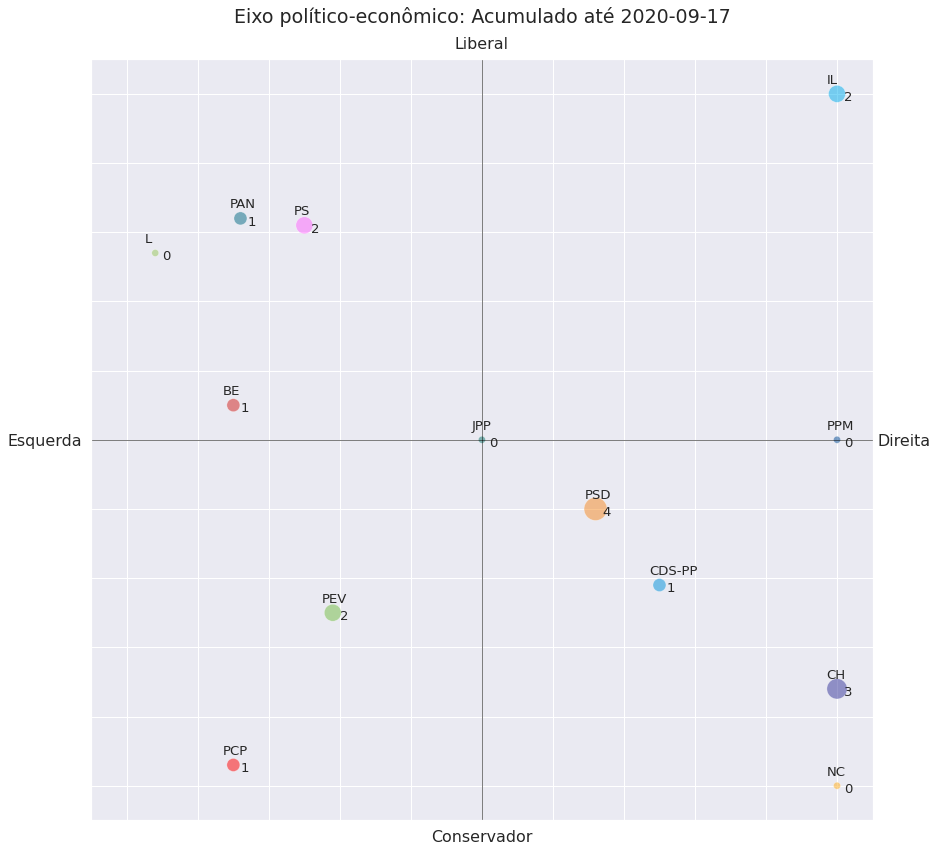

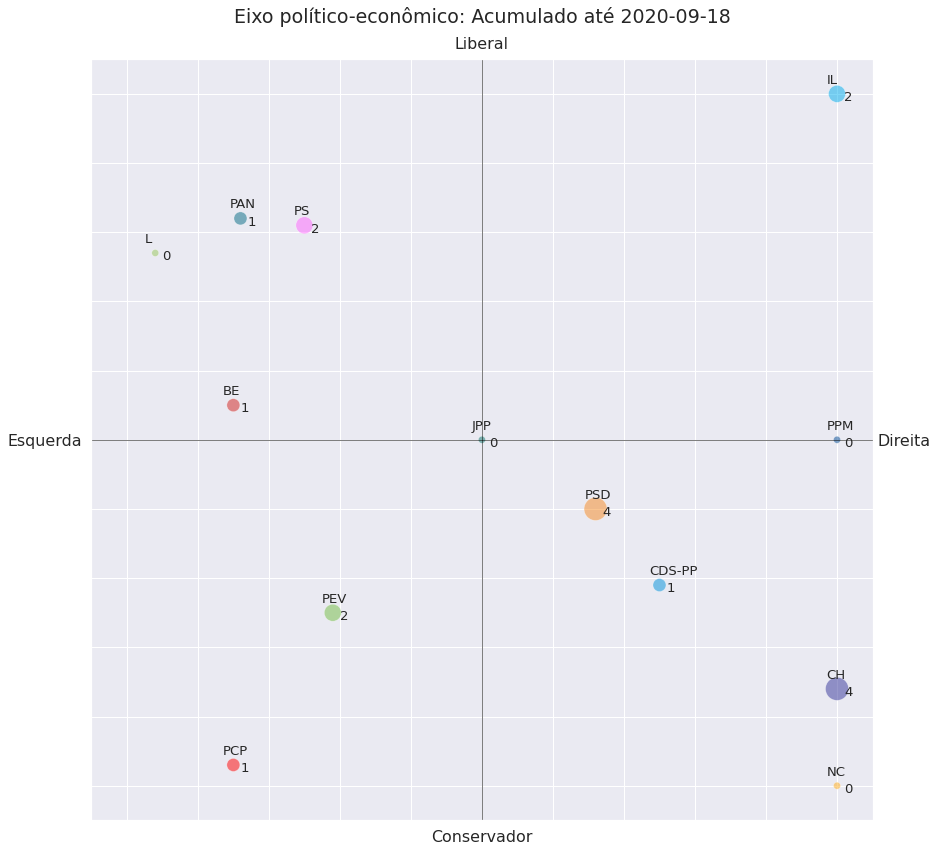

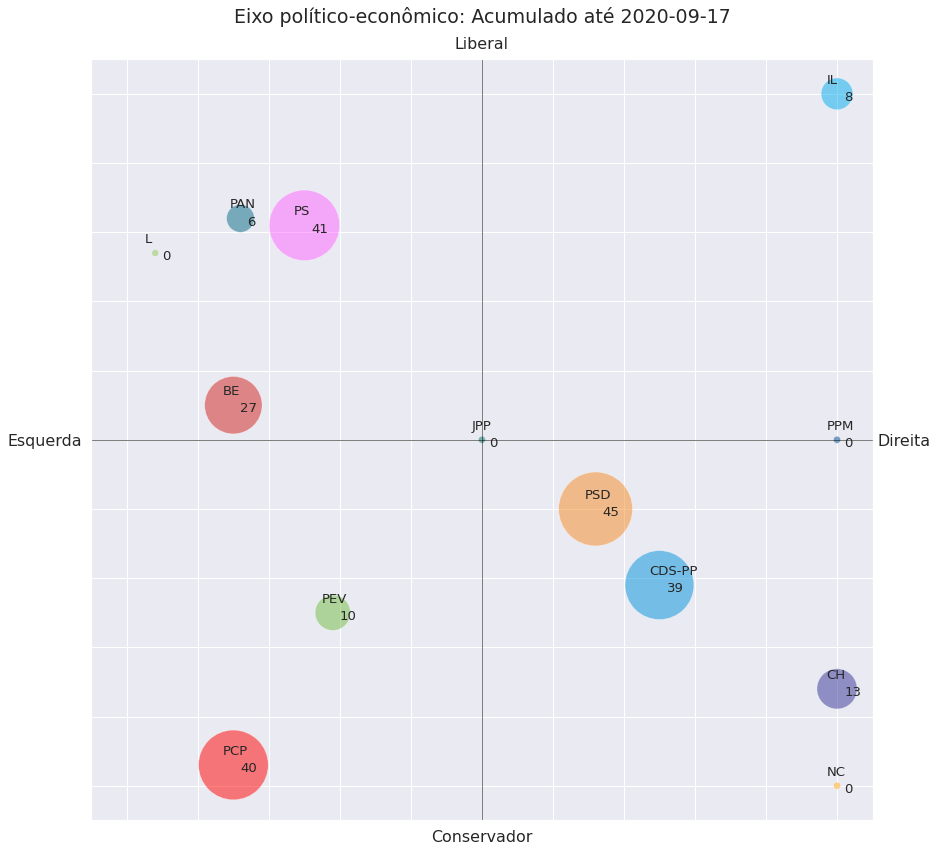

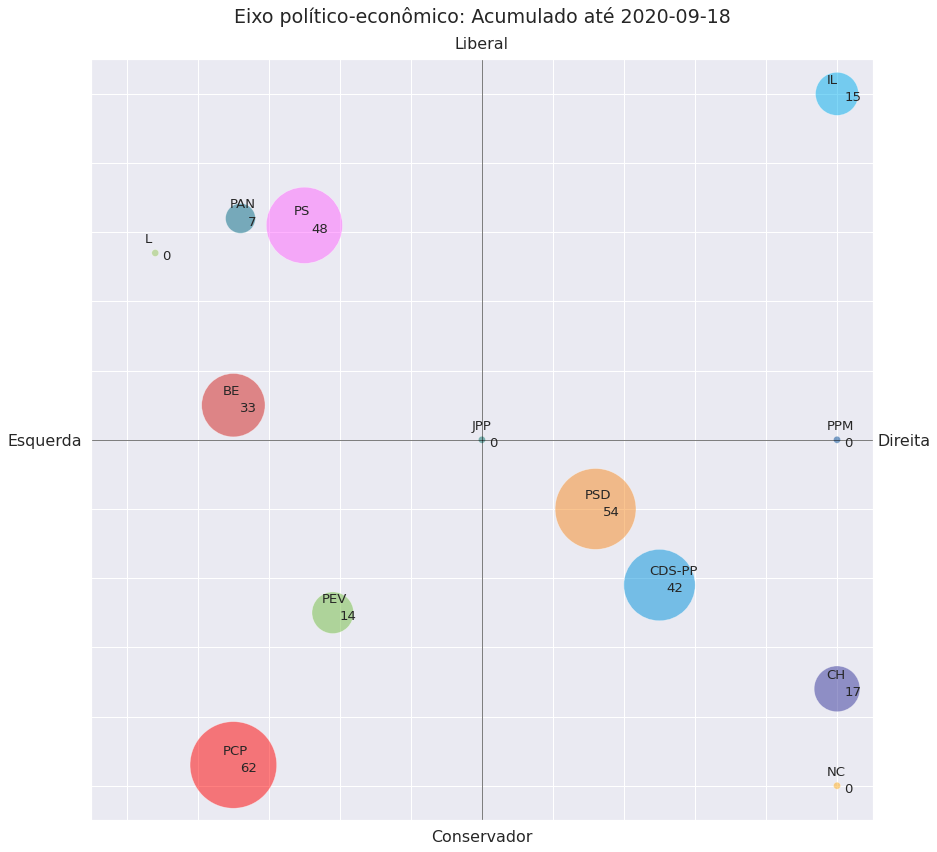

In [12]:
create_gif(direct_dict, direct_dates, 'direct-citations')
create_gif(indirect_dict, indirect_dates, 'indirect-citations')

# Direct Citations

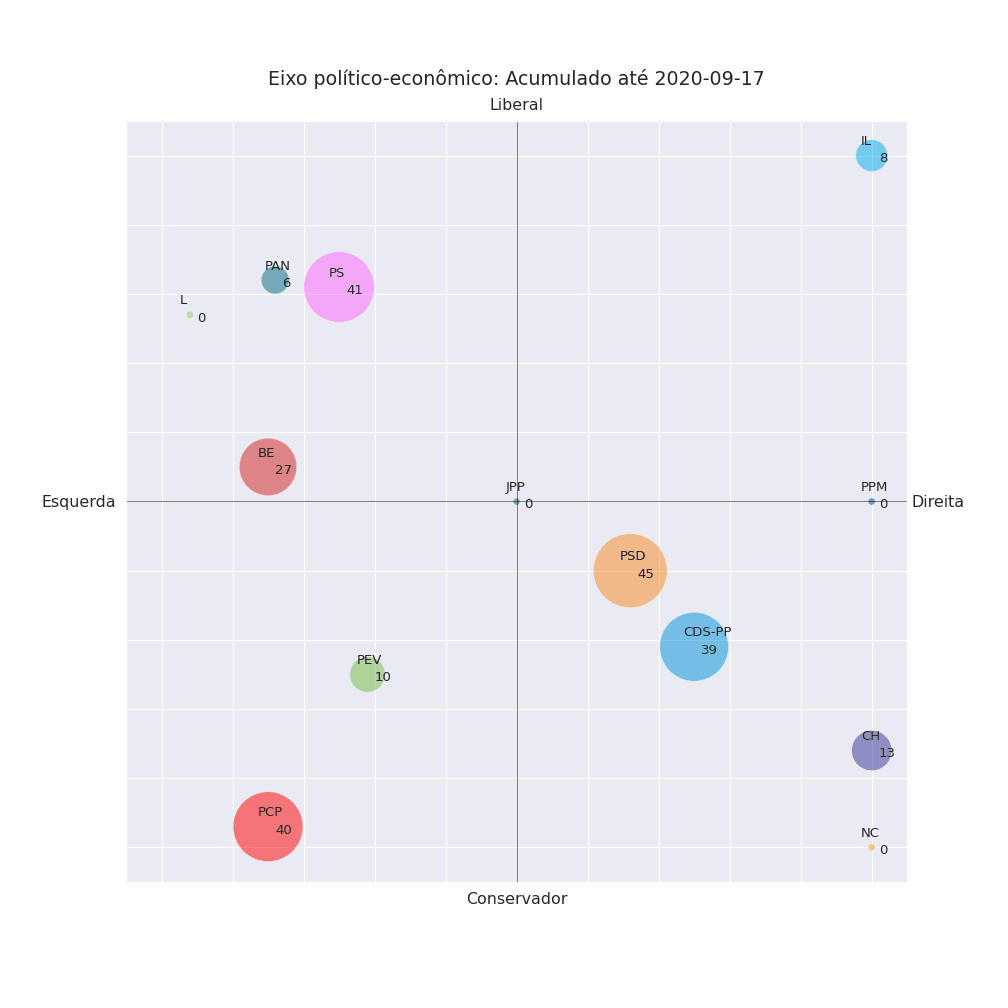

#Indirect Citations

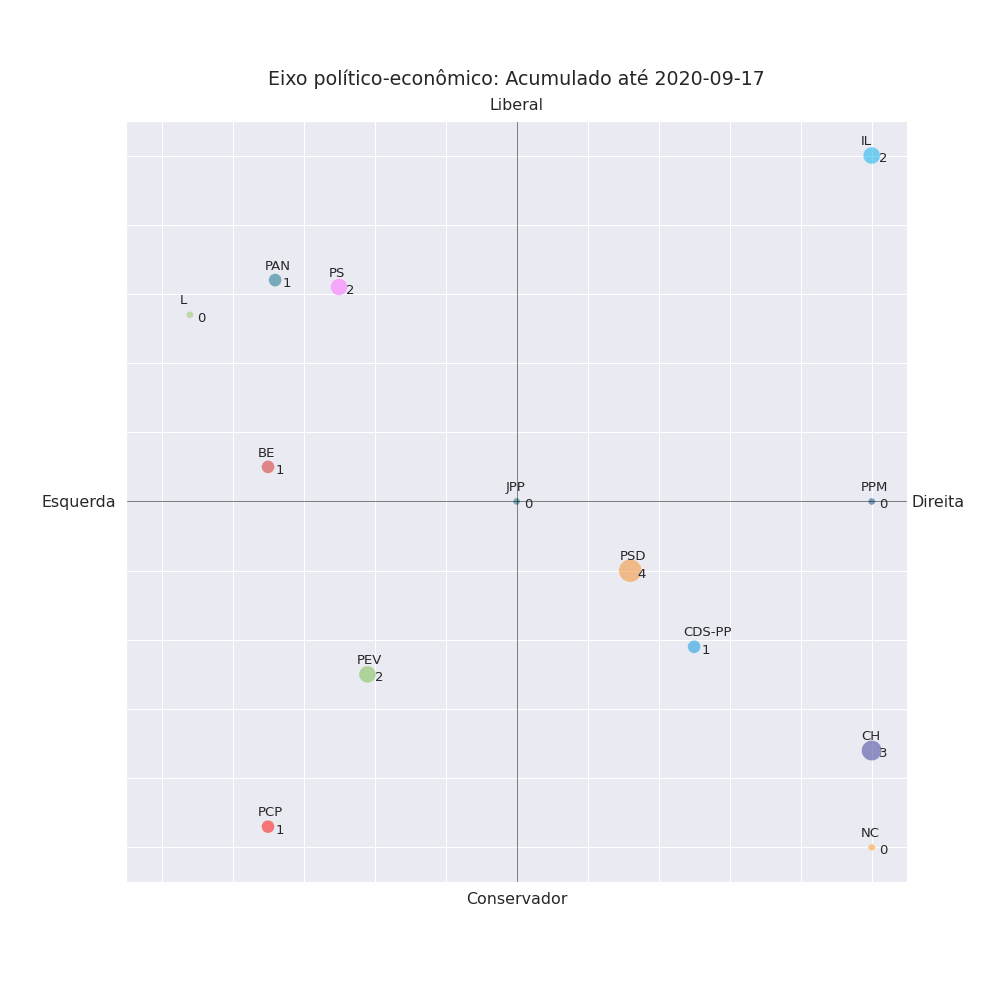